# 환경 설정

In [2]:
import koreanize_matplotlib

%config InlineBackend.figure_format = 'retina'

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
import os

# 작업 디렉토리 변경
os.chdir("C:/Users/kjh25/zerobase/myenv/파이널플젝")

# 변경된 작업 디렉토리 확인
print("Current working directory: ", os.getcwd())

Current working directory:  C:\Users\kjh25\zerobase\myenv\파이널플젝


In [4]:
df = pd.read_csv('customer_buyinginfo_df.csv')
rfm_df = df[['고객ID', '최근거래날짜', '구매횟수', '총결제금액']]

In [7]:
import datetime
today = datetime.date(2019, 12, 31)
rfm_df['최근거래날짜'] = [(today - datetime.date.fromisoformat(i)).days + 1 for i in rfm_df['최근거래날짜']]
rfm_df.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
rfm_df

C:\Users\kjh25\AppData\Local\Temp\ipykernel_16732\1274889407.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_df['최근거래날짜'] = [(today - datetime.date.fromisoformat(i)).days + 1 for i in rfm_df['최근거래날짜']]


,CustomerID,Recency,Frequency,Monetary
0,USER_0000,108,1,99.98
1,USER_0001,60,31,15308.13
2,USER_0002,74,8,1573.49
3,USER_0003,18,11,1421.96
4,USER_0004,108,13,1524.42
...,...,...,...,...
1463,USER_1463,271,3,676.73
1464,USER_1464,88,19,2606.18
1465,USER_1465,195,2,127.90
1466,USER_1466,70,1,333.80


# RFM

### 전체 주문에서 최근 주문일 구하기

In [19]:
# # Recency 계산을 위해 해당 주문에서 가장 최근 구매가 일어난 시간을 가져옵니다.
# # 최근 거래 기준일(last_timestamp)을 만들기 위해 timedelta로 날짜를 더해줍니다.(최소값:1 설정)
# # timedelta(days=0, seconds=0, microseconds=0, milliseconds=0, minutes=0, hours=0, weeks=0)
# import datetime as dt

# rfm_df['거래날짜'] = pd.to_datetime(rfm_df['거래날짜'])

# last_timestamp = rfm_df['거래날짜'].max() + dt.timedelta(days=1)
# last_timestamp

### 고객별 Recency, Frequency, Monetary 값 구하기

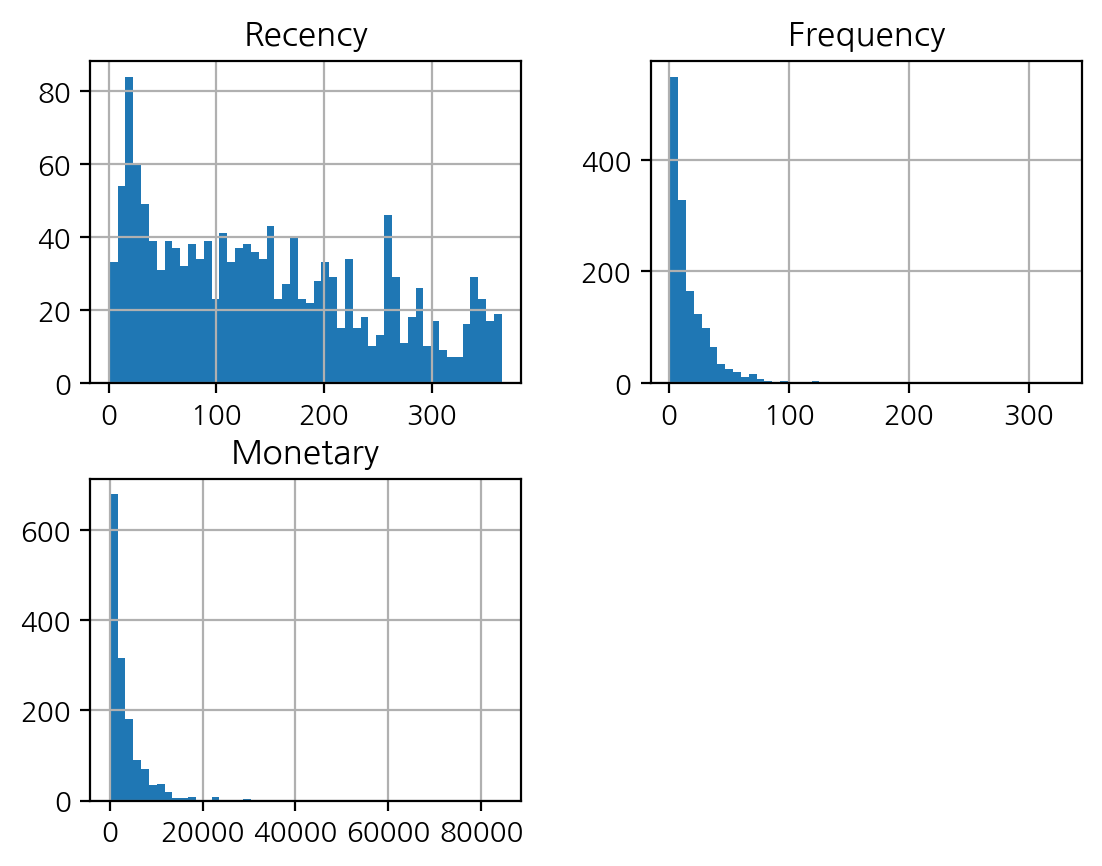

In [8]:
# 히스토그램은 cut 방식입니다. 
# => 한쪽에 고객이 치우쳐져있어서 몰려있는 부분을 제대로 분석하기 어렵기 때문에 고르게 분포가 되도록 분석해볼 예정입니다.
rfm_df.hist(bins=50);

## RFM 모형

* Scoring 기법: RFM의 요인을 각각 5등급으로 등간격으로 분류하는 방법이다.
* 현재 개발된 RFM 모형은 크게 4가지로 분류 할 수 있다. 이 문서의 내용들은 정설이 아니며 신뢰하기 어려움을 전제로 참고해야한다.
    * 모델1. RFM 각 요소의 20% rule의 적용
    * 모델2. 비율 척도에 의한 양적인 정도의 차이에 따른 등간격의 5등급 분류
    * 모델3. 상하 20%를 제외한 등간격 척도에 의한 그룹 분류
    * 모델4. 군집 분석에 의한 각 요소 별 5개의 그룹 분류
    
출처 : [RFM - 위키백과, 우리 모두의 백과사전](https://ko.wikipedia.org/wiki/RFM)

### qcut을 통한 RFM 변수 만들기

<img src="https://t1.daumcdn.net/cfile/tistory/99DEAF3B5C1E4AAA1E">

In [9]:
# F, M 는 값이 높을 수록 높은 점수를 줄 예정
# R은 값이 낮을 수록 최근에 구매한 고객이기 때문에 높은 점수를 줄 예정입니다.
# [5, 4, 3, 2, 1] 이 되게 range, list 를 활용해서 만든다면?
# Recency 는 최근일수록 높은 스코어를 갖도록 합니다.
# Frequency, MonetaryValue 는 값이 클 수록 높은 스코어를 갖도록 합니다.
r_labels = list(range(5, 0, -1))
f_labels = list(range(1, 6))
m_labels = list(range(1, 6))
cut_size = 5

In [10]:
pd.qcut(range(10), 3, labels=["good", "medium", "bad"])

['good', 'good', 'good', 'medium', 'medium', 'medium', 'bad', 'bad', 'bad', 'bad']
Categories (3, object): ['good' < 'medium' < 'bad']

In [11]:
pd.qcut(range(12), 4, labels=[1, 2, 3, 4])

[1, 1, 1, 2, 2, ..., 3, 3, 4, 4, 4]
Length: 12
Categories (4, int64): [1 < 2 < 3 < 4]

In [12]:
# 머신러닝에서도 연속된 수치 데이터를 구간화 해서 사용하게 되면 오버피팅(과적합) 되는 현상을 방지할 수도 있습니다.
# 오버피팅(과적합)이란 학습데이터에 너무 치중해서 학습데이터에서는 좋은 성능을 내지만
# 실제 데이터에서는 좋은 성능을 내지 못하는 것을 의미합니다.
r_cut = pd.qcut(rfm_df["Recency"], cut_size, labels=r_labels)
f_cut = pd.qcut(rfm_df["Frequency"], cut_size, labels=f_labels)
m_cut = pd.qcut(rfm_df["Monetary"], cut_size, labels=m_labels)

In [13]:
# assign 을 사용하면 여러 변수를 한 번에 만들 수 있습니다.
rfm = rfm_df.assign(R=r_cut, F=f_cut, M=m_cut)
rfm

,CustomerID,Recency,Frequency,Monetary,R,F,M
0,USER_0000,108,1,99.98,3,1,1
1,USER_0001,60,31,15308.13,4,5,5
2,USER_0002,74,8,1573.49,4,2,3
3,USER_0003,18,11,1421.96,5,3,3
4,USER_0004,108,13,1524.42,3,3,3
...,...,...,...,...,...,...,...
1463,USER_1463,271,3,676.73,1,1,2
1464,USER_1464,88,19,2606.18,4,4,4
1465,USER_1465,195,2,127.90,2,1,1
1466,USER_1466,70,1,333.80,4,1,1


### RFM Segment

In [14]:
# RFM_segment 값을 구합니다. 
# R, F, M 값을 문자 그대로 붙여서 세그먼트를 구분합니다.
rfm["RFM_segment"] = rfm["R"].astype(str) + rfm["F"].astype(str) + rfm["M"].astype(str)

### RFM Score

In [15]:
# R, F, M 값의 합계를 구해서 세그먼트 점수를 구합니다.
rfm["RFM_score"] = rfm[["R", "F", "M"]].sum(axis=1)
rfm.head(2)

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_segment,RFM_score
0,USER_0000,108,1,99.98,3,1,1,311,5
1,USER_0001,60,31,15308.13,4,5,5,455,14


<Axes: xlabel='RFM_segment', ylabel='RFM_score'>

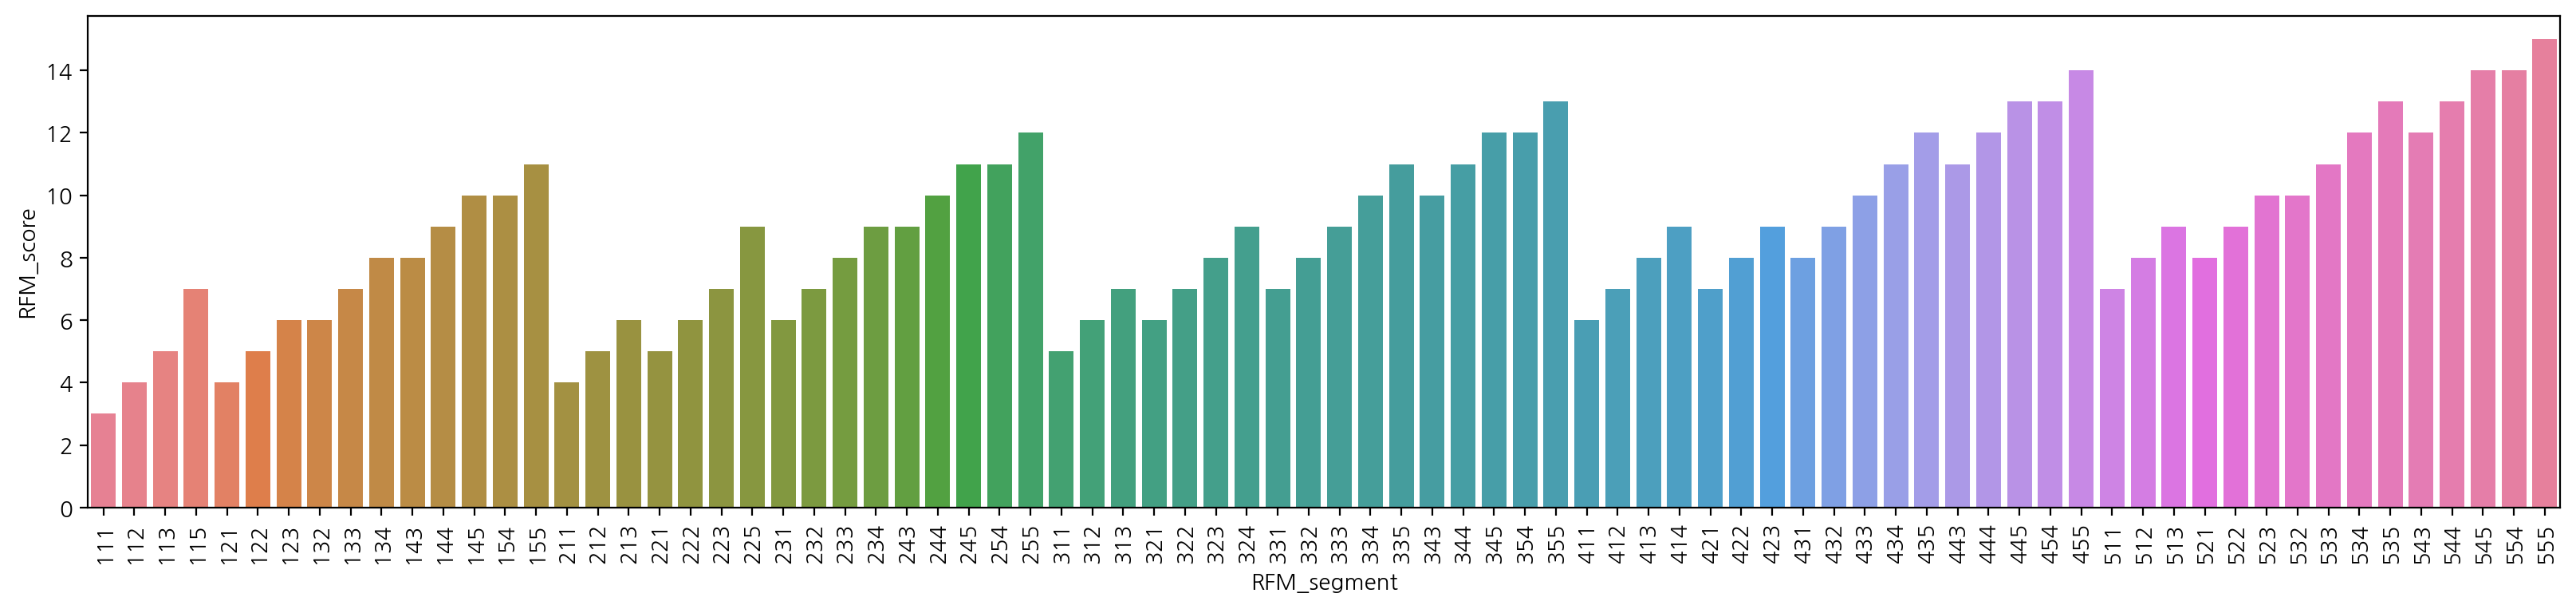

In [16]:
# RFM segment 값에 따라 정렬합니다.
plt.figure(figsize=(20, 4))
plt.xticks(rotation=90)
sns.barplot(data=rfm.sort_values("RFM_segment"), x="RFM_segment", y="RFM_score", hue = 'RFM_segment')

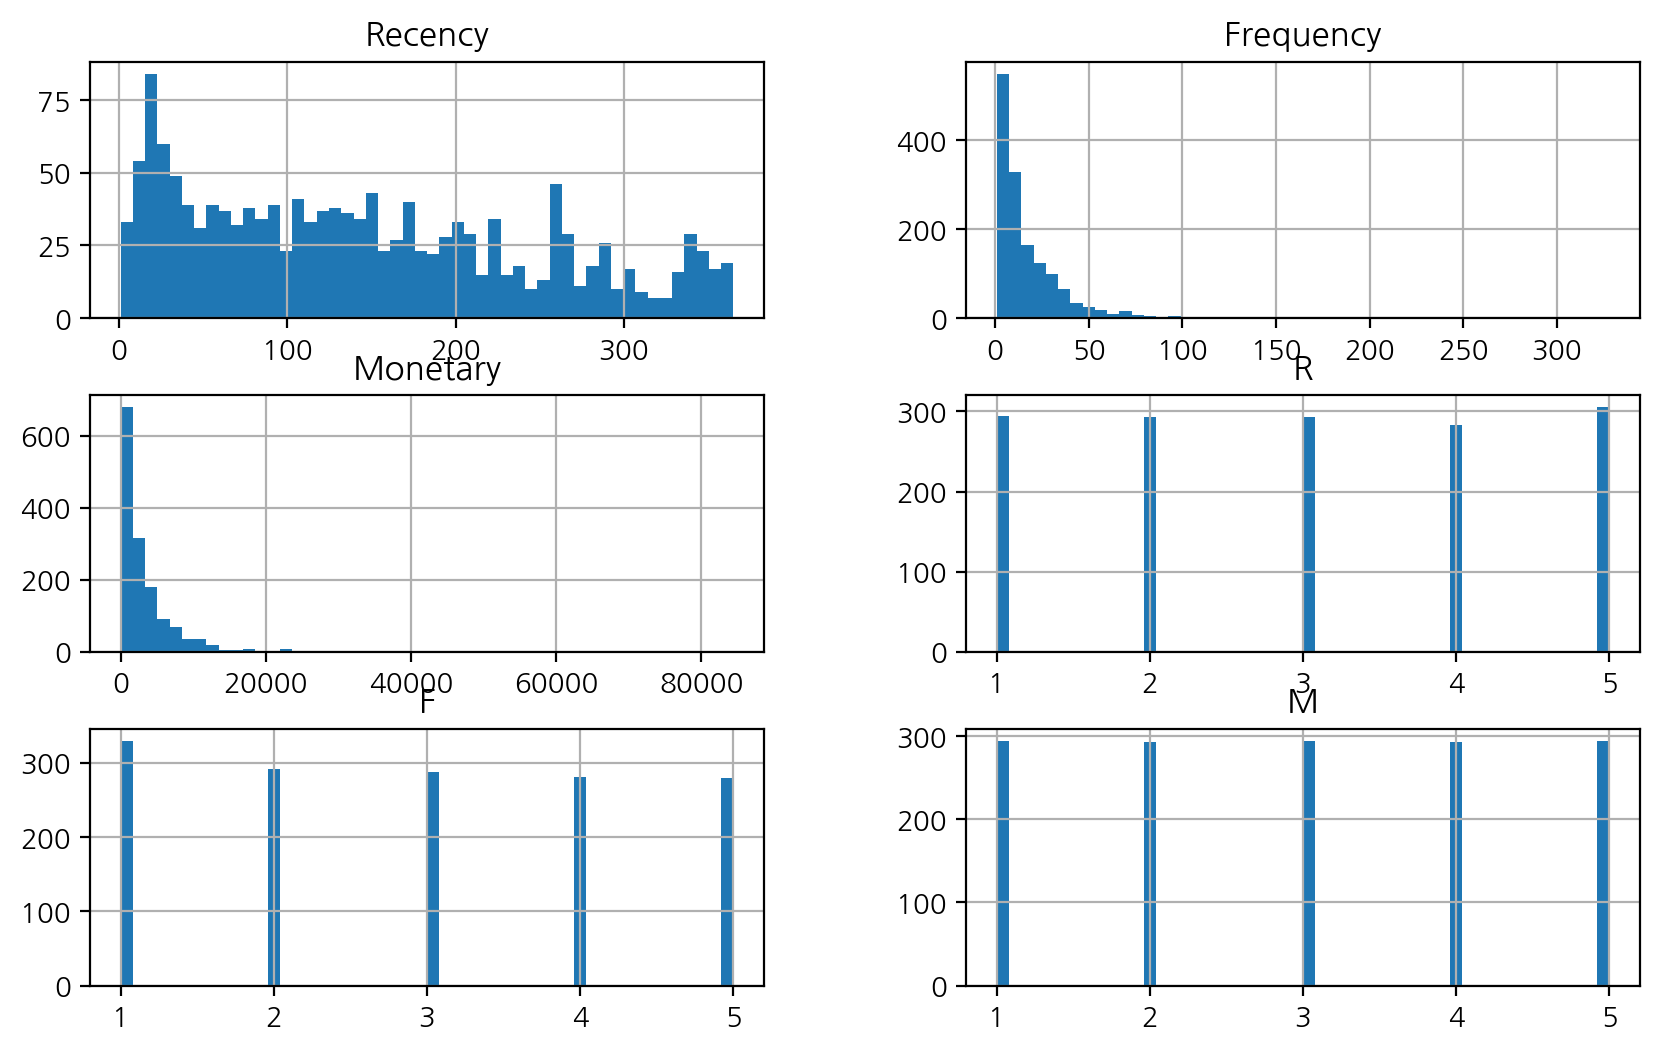

In [17]:
# RFM 을 구간화 하면 기존에 몰려있던 데이터가 같은 비율로 나뉜 것을 볼 수 있습니다.
rfm.iloc[:, 1:-2].astype(float).hist(figsize=(10, 6), bins=50);

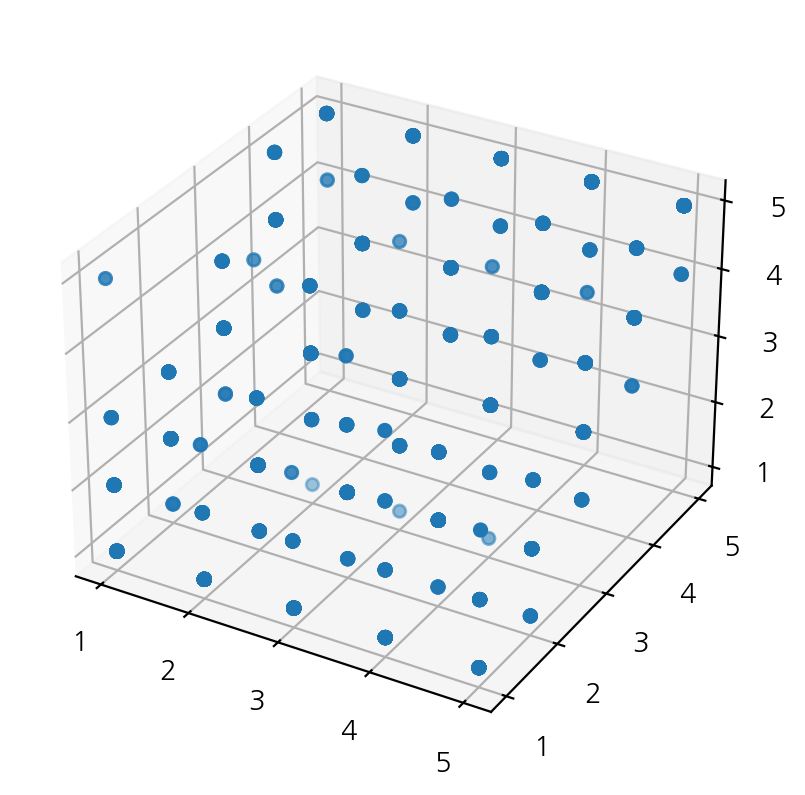

In [18]:
# 3d projection ax.scatter3D rfm["R"], rfm["F"], rfm["M"]
# 데이터가 균일하게 퍼져있는 것을 확인
ax = plt.axes(projection='3d')
ax.scatter3D(rfm["R"], rfm["F"], rfm["M"])

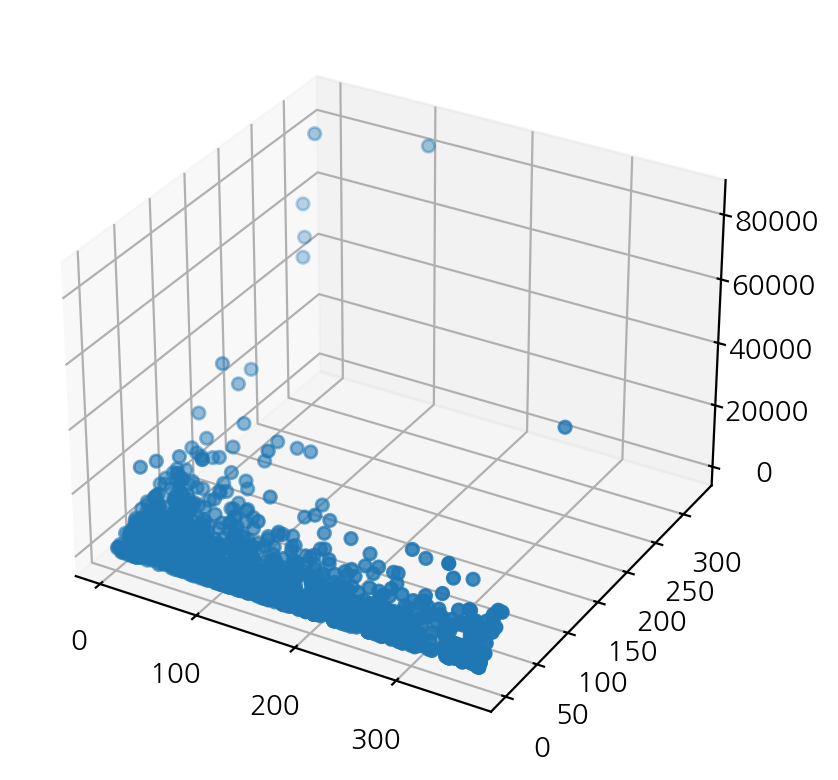

In [19]:
# rfm["Recency"], rfm["Frequency"], rfm["MonetaryValue"]
# 등급을 나누지 않았을 경우에는 몰려있어서 세분화의 어려움이 있음
ax = plt.axes(projection='3d')
ax.scatter3D(rfm["Recency"], rfm["Frequency"], rfm["Monetary"])

In [20]:
# 문자열의 format 함수를 사용하여 소수점 아래는 표기하지 않도록({:,.0f}) 문자열 포맷을 지정합니다.
rfm.groupby("RFM_score").agg({"Recency": "mean", 
                              "Frequency" : "mean", 
                              "Monetary" : ["mean", "sum"]
                             }).style.background_gradient().format("{:,.0f}")

### 기준에 맞추어 고객군 나누기
- vvip + vip(매우 중요 + 중요 고객)
rf 4 이상 m은 3 이상
- loyal customers(충성 곡개)
f는 4이상, rm은 다양
- potential loyalists(잠재적 충성 고객)
rf는 중간 이상 m은 무난
- new customers(신규고객)
r은 4이상 fm은 점수가 낮을 수 있음
- At risk(위험에 처한 고객) + can't lose them(잃으면 안되는 고객)
r이 2 이하이나 fm 점수가 중간 이상
r점수가 1 이하이나 fm이 4 이상임
- lost(이탈 고객)
rfm모두 낮음
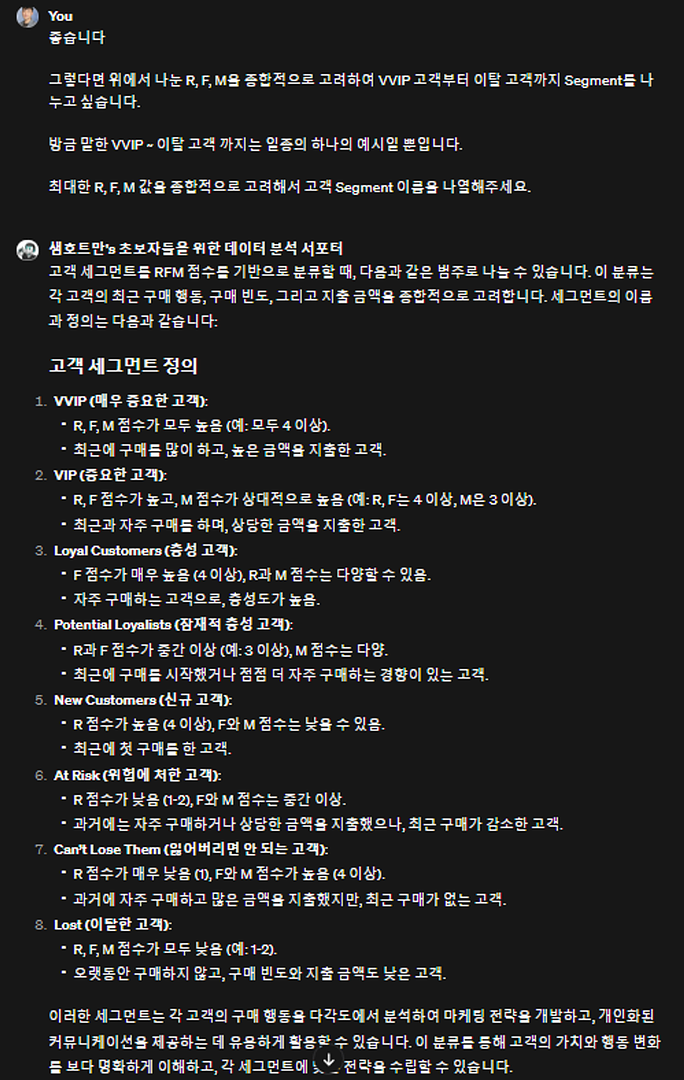

In [21]:
# def assign_segment_updated(row):
#   if row['R'] >=4 and row['F'] >=4:
#     return 'VIP'
#   elif row['F'] >=4:
#     return 'Loyal Customers'
#   elif row['R'] >=3 and row['F'] >=3:
#     return 'Potential Loyalists'
#   elif row['R'] >=4:
#     return 'New Customers'
#   elif row['R'] <=2 and row['F'] >=3:
#     return 'At Risk'
#   elif row['R'] ==1 and row['F'] >=4 and row['M']>= 4:
#     return "At Risk"
#   else: return 'Others'

# rfm['Segment'] = rfm.apply(assign_segment_updated, axis=1)
# rfm


In [22]:
def assign_segment_updated(row):
  if row['R'] >=4 and row['F'] >=4:
    return 'VIP' # 매우 중요
  elif row['F'] >=4:
    return 'Loyal Customers' # 충성고객
  elif (row['R'] >=3 and row['F'] >=3)|(row['R'] >=3 and row['M'] >=3):
    return 'Potential Loyalists' # 잠재적 충성 고객, 빈도는 낮아도 최근에 들어와서 돈을 썼다면 잠재적 충성 고객이 아닐까?
  elif row['R'] >=4:
    return 'New Customers' # 신규 고객
  elif row['R'] <=2 and row['F'] >=3:
    return 'At Risk' # 위험에 처한 고객
  elif row['R'] ==1 and row['F'] >=3 and row['M']>= 3:
    return "At Risk" #잃으면 안되는 고객
  elif row['R'] == 3 or row['F'] == 3 or row['M'] == 3:
    return 'At Risk' # rmf 중에 하나라도 3인 경우에는 이탈 고객이라고 보기 어렵거나 놓치기 어려운 고객이라고 판단하여 at risk로 엮음
  else: return 'Others'

# 최근 빈도 금액
rfm['Segment'] = rfm.apply(assign_segment_updated, axis=1)
rfm

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_segment,RFM_score,Segment
0,USER_0000,108,1,99.98,3,1,1,311,5,At Risk
1,USER_0001,60,31,15308.13,4,5,5,455,14,VIP
2,USER_0002,74,8,1573.49,4,2,3,423,9,Potential Loyalists
3,USER_0003,18,11,1421.96,5,3,3,533,11,Potential Loyalists
4,USER_0004,108,13,1524.42,3,3,3,333,9,Potential Loyalists
...,...,...,...,...,...,...,...,...,...,...
1463,USER_1463,271,3,676.73,1,1,2,112,4,Others
1464,USER_1464,88,19,2606.18,4,4,4,444,12,VIP
1465,USER_1465,195,2,127.90,2,1,1,211,4,Others
1466,USER_1466,70,1,333.80,4,1,1,411,6,New Customers


In [23]:
# 트리맵의 others의 비율이 높아 확인해보기
rfm.loc[rfm.Segment=='Others', 'RFM_segment'].unique()

array(['222', '211', '221', '111', '122', '112', '212', '115', '121',
       '225'], dtype=object)

In [24]:
rfm.groupby("Segment")["RFM_segment"].describe()

,count,unique,top,freq
Segment,,,,
At Risk,267,15,311,61
Loyal Customers,261,15,344,38
New Customers,140,8,422,31
Others,282,10,111,76
Potential Loyalists,219,22,533,45
VIP,299,10,555,84


In [25]:
# "RFM_class" 별로 그룹화합니다.
# "Recency", "Frequency" 의 평균을 구합니다.
# "MonetaryValue"의 "mean", "sum", "count" 값을 구합니다.
rfm_class_agg = rfm.groupby("Segment").agg({"Recency": "mean", 
                              "Frequency": "mean",
                             "Monetary": ["mean", "sum", "count"]})

In [26]:
# 위에서 구한 값을 .style.background_gradient() 통해서 시각화합니다.
rfm_class_agg.style.background_gradient(cmap="Oranges").format("{:,.0f}")

In [27]:
# pairplot 을 통해 "RFM_class" 별로 분포를 시각화 합니다.
# sns.pairplot(data=rfm.sample(1000), hue="Segment")

In [28]:
# .corr() 함수로 변수간 상관관계(선형적 관계)를 분석합니다.
# 1에 가까울 수록 양의 상관관계, -1에 가까울 수록 음의 상관관계를 나타냅니다.
corr = rfm.corr(numeric_only=True)
corr

,Recency,Frequency,Monetary,RFM_score
Recency,1.000000,-0.218934,-0.203853,-0.605031
Frequency,-0.218934,1.000000,0.949237,0.617552
Monetary,-0.203853,0.949237,1.000000,0.575339
RFM_score,-0.605031,0.617552,0.575339,1.000000


In [29]:
# 삼각형태의 heatmap 형태를 만들기 위해 삼각형 마스크를 만듭니다.
mask = np.triu(np.ones_like(corr))

<Axes: >

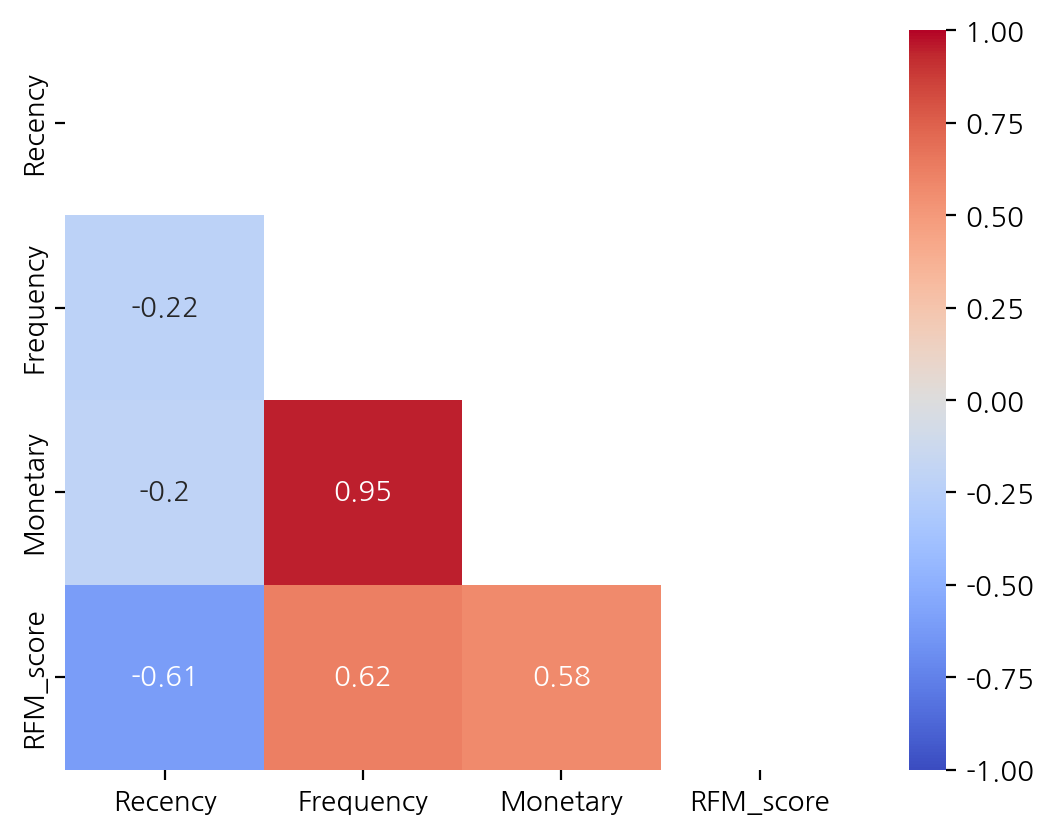

In [30]:
# 상관관계를 열분포 형태의 이미지로 보여주는 heatmap 으로 데이터 시각화합니다.
sns.heatmap(corr, cmap="coolwarm", vmin=-1, vmax=1, annot=True, mask=mask)

In [31]:
import squarify

In [32]:
rfm.groupby(by='Segment').count()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_segment,RFM_score
Segment,,,,,,,,,
At Risk,267,267,267,267,267,267,267,267,267
Loyal Customers,261,261,261,261,261,261,261,261,261
New Customers,140,140,140,140,140,140,140,140,140
Others,282,282,282,282,282,282,282,282,282
Potential Loyalists,219,219,219,219,219,219,219,219,219
VIP,299,299,299,299,299,299,299,299,299


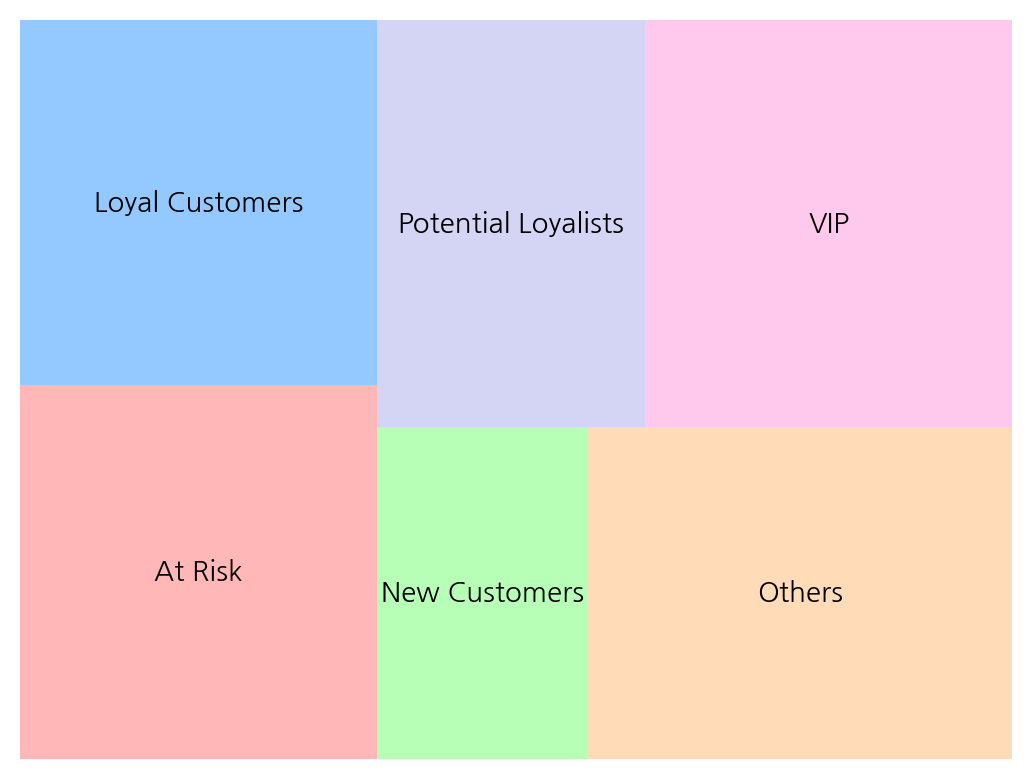

In [33]:
# 트리맵을 그릴 값을 추출
seg = rfm.groupby(by='Segment').count()
sizes = seg['R'].values

colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99', '#c2c2f0', '#ffb3e6']

# Squarify 모듈이 요구하는 형식에 맞게 가공
squarify.plot(sizes, label=seg.index, alpha=.7, color=colors)

# 플롯 스타일 설정
plt.axis('off')

# 트리맵 출력
plt.show()